In [24]:
!nvidia-smi

Mon May  1 23:03:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   38C    P0    56W / 300W |  23584MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install --user diffusers torch torchvision transformers accelerate

You should consider upgrading via the '/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
from contextlib import nullcontext
from PIL import Image
from typing import List, Union, Tuple


from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionPipeline
import torch
from torch.cuda.amp import autocast
import torch.nn as nn
from torchvision.transforms import PILToTensor
from tqdm.auto import tqdm

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
class LatentDIRE(nn.Module):
    def __init__(
        self,
        device: torch.device,
        pretrained_model_name: str = "CompVis/stable-diffusion-v1-4",
        generator: torch.Generator = torch.Generator().manual_seed(1),
        use_fp16: bool = False,
    ) -> None:
        super().__init__()
        self.device = device
        self.generator = generator
        self.use_fp16 = use_fp16

        assert pretrained_model_name in [
            "CompVis/stable-diffusion-v1-4",
            "runwayml/stable-diffusion-v1-5",
            # "stabilityai/stable-diffusion-2-1", TODO: enable prediction_type=v_predict in _ddim_inversion
        ], f"Model {pretrained_model_name} not supported. Must be one of 'CompVis/stable-diffusion-v1-4', 'runwayml/stable-diffusion-v1-5'" #, 'stabilityai/stable-diffusion-2-1'"
        self.scheduler = DDIMScheduler.from_config(pretrained_model_name, subfolder="scheduler")
        self.inversion_scheduler = DDIMInverseScheduler.from_config(pretrained_model_name, subfolder="scheduler")
        self.pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name,
            safety_checker=None,
            scheduler=self.scheduler,
            torch_dtype=torch.float16 if use_fp16 else torch.float32,
        ).to(device)

    @torch.no_grad()
    def forward(
        self,
        x: torch.Tensor,
        n_steps: int = 20,  # cf. section 4.1 in the DIRE paper
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Compute DIRE(x).

        Args:
            x (torch.Tensor):
                Batch of images.
            n_steps (int, optional):
                Number of steps to take. Defaults to 20.
        Returns:
            Tuple[torch.Tensor, ...]: DIRE(x), DIRE(z), reconstruction, latent_reconstruction, latent
        """
        latent = self.encode(x)
        self.scheduler.set_timesteps(n_steps)
        noise = self._ddim_inversion(latent)
        batch_size = noise.shape[0]
        noise = noise.to(dtype=torch.float16 if self.use_fp16 else torch.float32)
        latent_reconstruction = self.pipe(prompt=[""] * batch_size, latents=noise, num_inference_steps=n_steps, output_type="latent", generator=self.generator).images
        latent_dire = torch.abs(latent - latent_reconstruction)
        reconstruction = self.decode(latent_reconstruction)
        dire = torch.abs(x - reconstruction)

        return dire, latent_dire, reconstruction, latent_reconstruction, latent

    def _ddim_inversion(self, latent: torch.Tensor) -> torch.Tensor:
        """from https://github.com/tejank10/null-text-inversion/blob/main/notebook.ipynb"""
        batch_size = latent.shape[0]
        encoder_hidden_state = self.pipe._encode_prompt([""] * batch_size, device=self.device, num_images_per_prompt=1, do_classifier_free_guidance=False)
        reverse_timestep_list = reversed(self.scheduler.timesteps)

        for i in tqdm(range(len(reverse_timestep_list) - 1), desc="inversion"):
            timestep = reverse_timestep_list[i]
            next_timestep = reverse_timestep_list[i + 1]
            latent_model_input = self.scheduler.scale_model_input(latent, timestep)
            with autocast() if self.use_fp16 else nullcontext():
                noise_pred = self.pipe.unet(latent_model_input, timestep, encoder_hidden_state).sample

            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
            beta_prod_t = 1 - alpha_prod_t
            beta_prod_t_next = 1 - alpha_prod_t_next

            pred_x0 = (latent - beta_prod_t**0.5 * noise_pred) / (alpha_prod_t**0.5)
            latent = alpha_prod_t_next**0.5 * pred_x0 + beta_prod_t_next**0.5 * noise_pred

        return latent

    @torch.no_grad()
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        with autocast() if self.use_fp16 else nullcontext():
            # fh: TODO: Use mean instead of sample?
            latent = self.pipe.vae.encode(x).latent_dist.sample(generator=self.generator)
        latent *= self.pipe.vae.config.scaling_factor
        return latent

    @torch.no_grad()
    def decode(self, latent: torch.Tensor, output_pil: bool = True) -> Union[torch.Tensor, List[Image.Image]]:
        """
        adapted from
        https://github.com/huggingface/diffusers/blob/4d35d7fea3208ddf1599e90b23ee95095b280646/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L441
        """
        latent /= self.pipe.vae.config.scaling_factor
        with autocast() if self.use_fp16 else nullcontext():
            image = self.pipe.vae.decode(latent).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.float()

        return image

    @staticmethod
    def tensor_to_pil(image: torch.Tensor) -> List[Image.Image]:
        """
        adapted from
        https://github.com/huggingface/diffusers/blob/716286f19ddd9eb417113e064b538706884c8e73/src/diffusers/pipelines/pipeline_utils.py#L815
        """
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        if image.ndim == 3:
            image = image[None, ...]
        image = (image * 255).round().astype("uint8")
        if image.shape[-1] == 1:
            # special case for grayscale (single channel) image
            pil_image = [Image.fromarray(image.squeeze(), mode="L") for image in image]
        else:
            pil_image = [Image.fromarray(image) for image in image]

        return pil_image

    @staticmethod
    def img_to_tensor(image: Union[str, Image.Image], use_fp16: bool = False, size: int = 512) -> torch.Tensor:
        if type(image) == str:
            image = Image.open(image)
        image = image.resize((size, size))
        image = image.convert("RGB")
        t = PILToTensor()(image)
        t = t.to(dtype=torch.float16 if use_fp16 else torch.float32)
        t = t / 127.5 - 1.0
        t = t.unsqueeze(0)
        return t


In [3]:
model_id = "CompVis/stable-diffusion-v1-4"
model_id = "runwayml/stable-diffusion-v1-5"
model_id = "stabilityai/stable-diffusion-2-1"
d = LatentDIRE(device)

/cluster/home/hehlif/.local/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/cluster/home/hehlif/.local/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim_inverse.DDIMInverseScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate

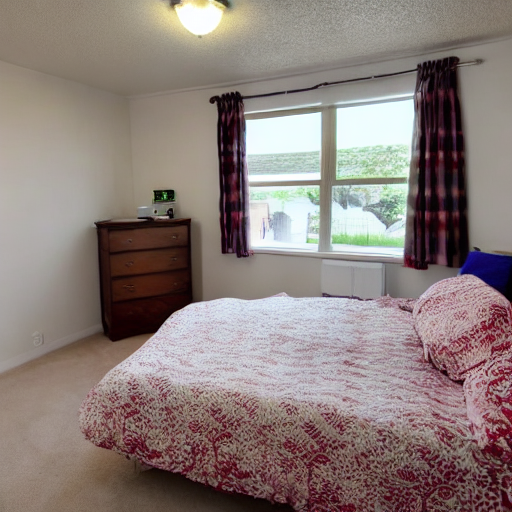

In [27]:
gen = d.pipe(prompt="A photo of a bedroom", generator=d.generator)[0][0]
gen

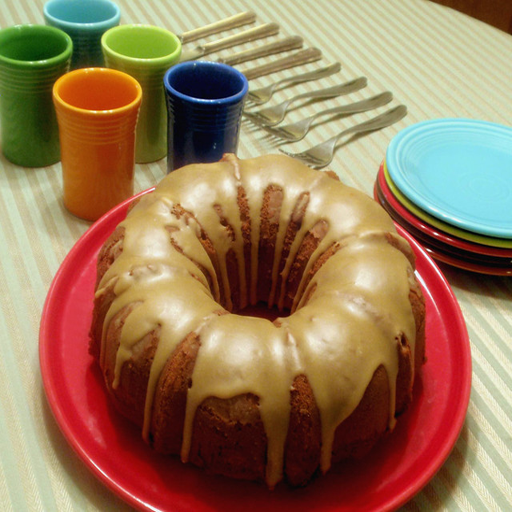

In [28]:
impaths = ["../data/examples/cake.jpg", "../data/examples/r0.jpg"]
batch = torch.cat([d.img_to_tensor(img) for img in [gen] + impaths])
Image.open(impaths[0]).resize((512,512))

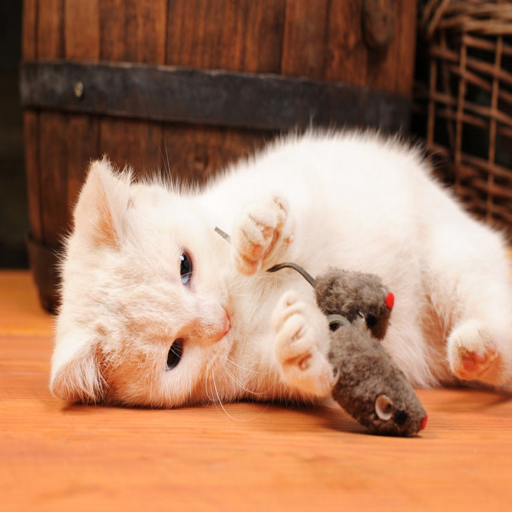

In [29]:
Image.open(impaths[1]).resize((512,512))

In [30]:
batch.shape

torch.Size([3, 3, 512, 512])

In [31]:
with torch.no_grad():
    dire, latent_dire, reconstruction, latent_reconstruction, latent = d(batch.to(device), n_steps=50)

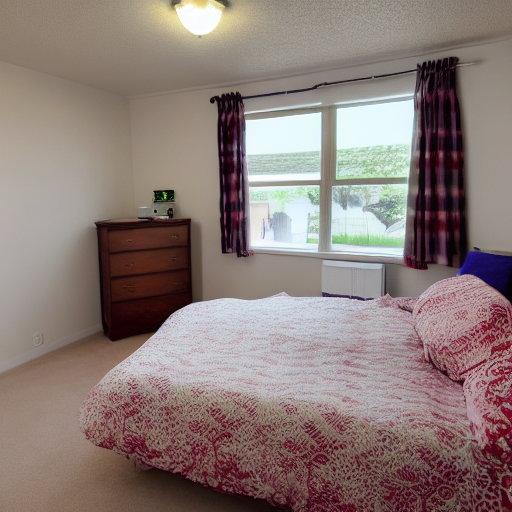

In [32]:
d.tensor_to_pil(reconstruction)[0]

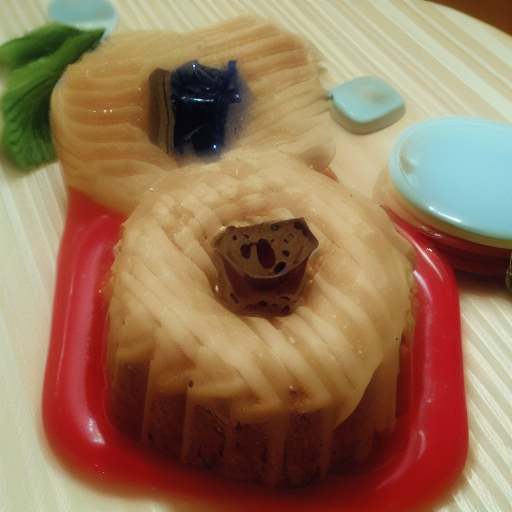

In [33]:
d.tensor_to_pil(reconstruction)[1]

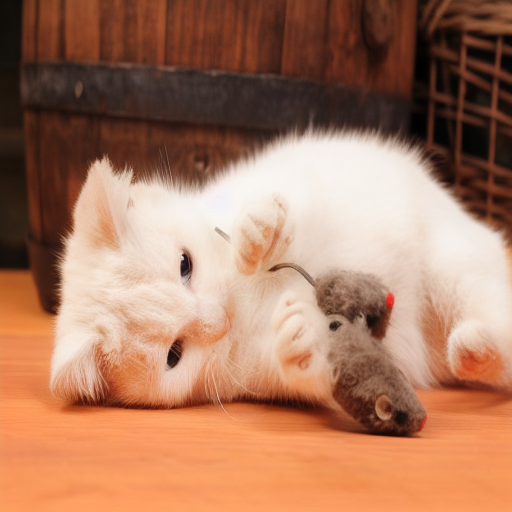

In [34]:
d.tensor_to_pil(reconstruction)[2]

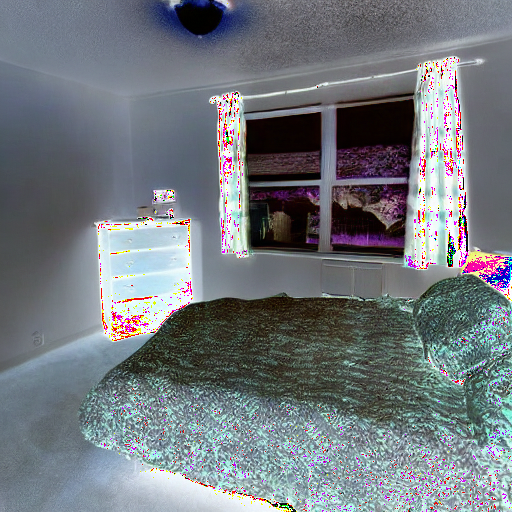

In [35]:
d.tensor_to_pil(dire)[0]

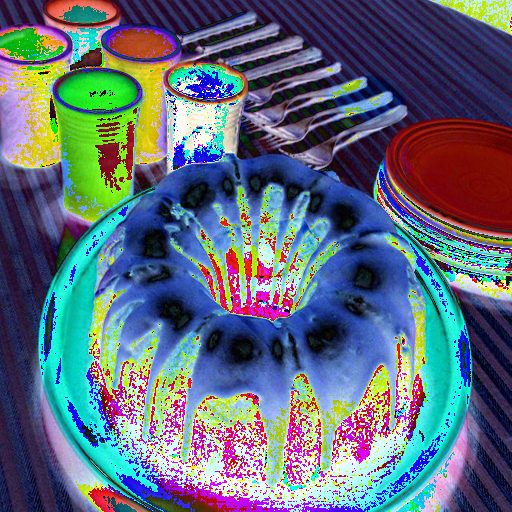

In [36]:
d.tensor_to_pil(dire)[1]

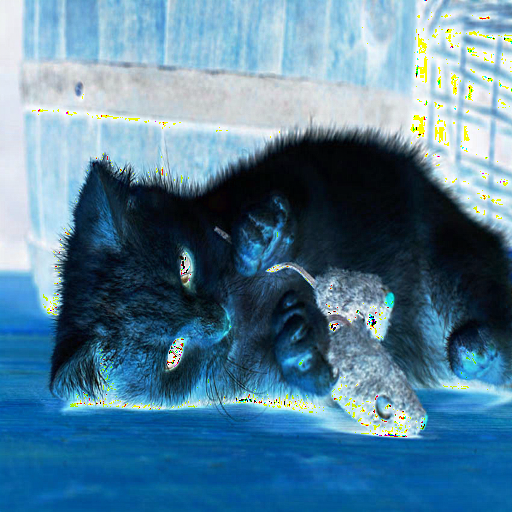

In [37]:
d.tensor_to_pil(dire)[2]

In [38]:
torch.linalg.norm(latent - latent_reconstruction, dim=(1,2,3))

tensor([429.9150, 459.7193, 572.2209], device='cuda:0')